# Prediction

In this stage, we'll take our cleaned dataset and experiment with different models to predict if a loan will default.

## Train-test split and normalization

We split our data into a train set and a test set, then normalise each set independently. By removing outliers in the data processing step we can be confident that the normalisation step is not being skewed by outliers. 


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import itertools

In [2]:
random_state = 10

In [3]:
def data_from_dataset(filename = "../../data/processed/loan_sampled_50000.csv"):
    df = pd.read_csv(filename, 
                low_memory = False)
    
    y = (df["target"]).astype(int)
    X = df.drop(columns = ["target"])
    X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, y, 
                                                   random_state = random_state,
                                                   train_size = 0.9)
    print(f"Train size: {X_train_orig.shape}\nTest size: {X_test_orig.shape}")
    return X_train_orig, X_test_orig, y_train, y_test

In [4]:
def normalize_df(df):
    scaler = MinMaxScaler()
    df = pd.DataFrame(scaler.fit_transform(df.values), 
                       columns=df.columns, index=df.index)
    return df

In [5]:
(X_train_orig, X_test_orig, y_train, y_test) = data_from_dataset("../../data/processed/loan_sampled_50000.csv")
X_train = normalize_df(X_train_orig)
X_test = normalize_df(X_test_orig)

/home/mikey/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/mikey/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Train size: (25935, 83)
Test size: (2882, 83)


We notice that there is a class imbalance in the dataset: there is significantly more non-default than default loans. 

The naive approach would be disregard this issue and expect imbalanced classes when the model is used in production. However, we are seeing a selected sample of the real-world data: we are not seeing applications refused due to being at high risk of default (assuming that the business already estimates this, as per the task description). By correcting for this sampling bias, we can train our algorithms to account for this situation.

We can take two resampling approaches to deal with this class imbalance problem:

- Oversampling the minority class

- Undersampling the majority class

There is a good discussion of approaches here: https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets. For simplicity, I will run the models on two datasets: the original training data, and an undersampled dataset (created by randomly removing instances of the majority class until the dataset is balanced. 

In [6]:
def undersample_dataset(X_train_orig, y_train):
    df_train = pd.concat([X_train_orig, y_train], axis = 1)
    count_class_0, count_class_1 = df_train.target.value_counts()
    df_class_0 = df_train[df_train['target'] == 0]
    df_class_1 = df_train[df_train['target'] == 1]
    df_class_0_under = df_class_0.sample(count_class_1)
    df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

    print(df_test_under.target.value_counts())
    X_train_under = df_test_under.drop(columns=["target"])
    y_train_under = df_test_under["target"].astype(int)

    scaler = MinMaxScaler()
    X_train_under = pd.DataFrame(scaler.fit_transform(X_train_under.values), 
                           columns=X_train_under.columns, index=X_train_under.index)
    return X_train_under, y_train_under

In [7]:
y_train.value_counts()

0    20544
1     5391
Name: target, dtype: int64

In [8]:
(X_train_under, y_train_under) = undersample_dataset(X_train_orig, y_train)

1    5391
0    5391
Name: target, dtype: int64


/home/mikey/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


## Model testing

We're going to try the following models:

- Logistic regression

- Decision trees

- Naive Bayes

- Random forest


To evaluate our models, we'll consider the following metrics:

- Confusion matrix

- Accuracy, precision, and recall

- ROC and AUC 

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
def plot_cm(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
def calc_metrics(conf_mat):
    tn, fp, fn, tp = conf_mat.ravel()
    accuracy = (tp + tn) / (tn + fp + fn + tp)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall}

def compare_models(X_train, X_test, y_train, y_test, plot_filename = None, title = None):
    results = []
    metrics_dict = {}
    labels = ["Random guess", "Logistic Regression", "Decision Tree", "Random Forest", "Gaussian"]

    logret = LogisticRegression(random_state = random_state)
    dt = DecisionTreeClassifier(random_state = random_state)
    randomforest = RandomForestClassifier(random_state = random_state)
    gauss = GaussianNB()
    models = [None, logret, dt, randomforest, gauss]
    
    for i in range(1, len(models)):
        model = models[i]

        model.fit(X_train, y_train)
        y_preds = model.predict(X_test)
        y_preds_probs = model.predict_proba(X_test)

        (fpr, tpr, thresholds) = roc_curve(y_test, y_preds_probs[:, 1])
        auc = roc_auc_score(y_test, y_preds_probs[:, 1])
        results.append((fpr, tpr, auc))
        # We want 'default' to be true positive
        conf_mat = confusion_matrix(y_test, y_preds, [1, 0])
        print(f"Model name: {labels[i]}")
        print(f"AUC      : {auc:.2f}")
        metrics = calc_metrics(conf_mat)
        print(f"Accuracy : {metrics['accuracy']:.2f}")
        print(f"Precision: {metrics['precision']:.2f}")
        print(f"Recall   : {metrics['recall']:.2f}")
        print(f"Confusion matrix: \n{conf_mat}")
    
        metrics_dict[labels[i]] = [auc, metrics['accuracy'], metrics['precision'], metrics['recall']]
    # Plot ROC curve
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.plot([0, 1], [0, 1], '--k', lw = 1)
    for res in results:
        ax.plot(res[0], res[1])
    legend = ["Random guess (N/A)"] + [f"{x} ({str(round(metrics_dict[x][3], 2))})" for x in labels[1:]]
    ax.legend(legend, loc = 4, title = "Model (recall)")
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    if plot_filename:
        fig1 = plt.gcf()
        plt.title(title)
        plt.draw()
        plt.savefig(fname = plot_filename)
    
    plt.show()
        
    return metrics_dict

### Imbalanced dataset

Model name: Logistic Regression
AUC      : 0.71
Accuracy : 0.80
Precision: 0.81
Recall   : 0.97
Confusion matrix: 
[[  82  519]
 [  65 2216]]
Model name: Decision Tree
AUC      : 0.54
Accuracy : 0.62
Precision: 0.81
Recall   : 0.67
Confusion matrix: 
[[ 246  355]
 [ 742 1539]]
Model name: Random Forest
AUC      : 0.64
Accuracy : 0.77
Precision: 0.81
Recall   : 0.94
Confusion matrix: 
[[  84  517]
 [ 134 2147]]
Model name: Gaussian
AUC      : 0.63
Accuracy : 0.73
Precision: 0.82
Recall   : 0.83
Confusion matrix: 
[[ 193  408]
 [ 378 1903]]


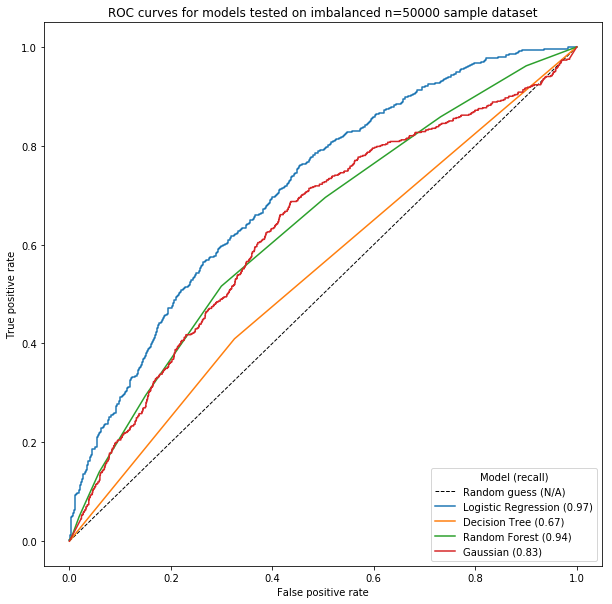

In [11]:
metrics_dict_imbalanced = compare_models(X_train, X_test, y_train, y_test, 
                                        "../../reports/figures/imbalanced_50000.png", 
                                        "ROC curves for models tested on imbalanced n=50000 sample dataset")

### Feature importance

When using a random forest classifier, we can see which features have the highest 'importance'.

As we can see below most of the features actually have a low importance. 

In [12]:
rf = RandomForestClassifier(random_state=random_state)
rf.fit(X_train, y_train)
feat_labels = X_train.columns
for feature in sorted(zip(rf.feature_importances_, feat_labels), reverse = True):
    print(feature)

(0.041188956638718285, 'int_rate')
(0.030022959205534862, 'dti')
(0.02889862216235809, 'installment')
(0.028394749895662496, 'loan:income_ratio')
(0.02632130552953273, 'mo_sin_old_rev_tl_op')
(0.025977860716023815, 'annual_inc')
(0.025494418076873405, 'revol_util')
(0.025238033533082727, 'mo_sin_old_il_acct')
(0.02492912416592308, 'bc_open_to_buy')
(0.024867757135534005, 'revol_bal')
(0.024632468802357917, 'tot_hi_cred_lim')
(0.0234756860316468, 'tot_cur_bal')
(0.023453987966918756, 'total_rev_hi_lim')
(0.02339379877435507, 'avg_cur_bal')
(0.02313380502569082, 'bc_util')
(0.023009088414968782, 'total_bc_limit')
(0.022748738244161012, 'loan_amnt')
(0.021771446739290313, 'total_bal_ex_mort')
(0.020635638901187168, 'total_acc')
(0.020492581101301387, 'mths_since_recent_bc')
(0.019893153536418316, 'total_il_high_credit_limit')
(0.01980171249028085, 'grade')
(0.016858141812546124, 'mo_sin_rcnt_rev_tl_op')
(0.01677933645811326, 'mo_sin_rcnt_tl')
(0.016184310860340292, 'acc_open_past_24mths')

### Balanced dataset

Model name: Logistic Regression
AUC      : 0.71
Accuracy : 0.65
Precision: 0.87
Recall   : 0.65
Confusion matrix: 
[[ 390  211]
 [ 807 1474]]
Model name: Decision Tree
AUC      : 0.56
Accuracy : 0.56
Precision: 0.83
Recall   : 0.55
Confusion matrix: 
[[ 337  264]
 [1016 1265]]
Model name: Random Forest
AUC      : 0.65
Accuracy : 0.64
Precision: 0.85
Recall   : 0.67
Confusion matrix: 
[[ 321  280]
 [ 752 1529]]
Model name: Gaussian
AUC      : 0.65
Accuracy : 0.73
Precision: 0.82
Recall   : 0.84
Confusion matrix: 
[[ 192  409]
 [ 374 1907]]


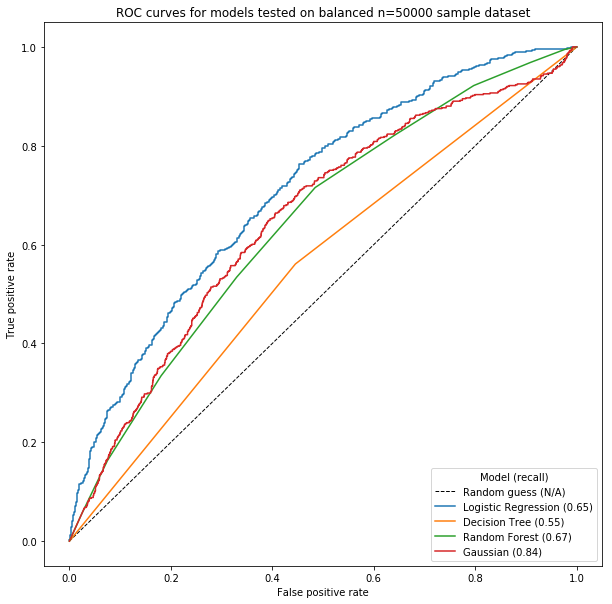

In [13]:
metrics_dict_balanced = compare_models(X_train_under, X_test, y_train_under, y_test,
                                      "../../reports/figures/balanced_50000.png",
                                      "ROC curves for models tested on balanced n=50000 sample dataset")

### Full dataset

We'll try now testing the algorithms on the full dataset. Note that for the sake of time we've been rather ruthless in dropping rows, so we're not using the full dataset as provided: nonetheless we have enough data to work with so we'll leave it there. 

To better reflect the environment the model will be used in, we'll test our models on an undersampled dataset with balanced classes.

/home/mikey/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Train size: (1172573, 83)
Test size: (130286, 83)
1    248693
0    248693
Name: target, dtype: int64


/home/mikey/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Model name: Logistic Regression
AUC      : 0.72
Accuracy : 0.62
Precision: 0.89
Recall   : 0.59
Confusion matrix: 
[[20261  7473]
 [42355 60197]]
Model name: Decision Tree
AUC      : 0.54
Accuracy : 0.54
Precision: 0.81
Recall   : 0.53
Confusion matrix: 
[[15115 12619]
 [47943 54609]]
Model name: Random Forest
AUC      : 0.63
Accuracy : 0.64
Precision: 0.84
Recall   : 0.67
Confusion matrix: 
[[14145 13589]
 [33478 69074]]
Model name: Gaussian
AUC      : 0.66
Accuracy : 0.72
Precision: 0.82
Recall   : 0.83
Confusion matrix: 
[[ 8890 18844]
 [17336 85216]]


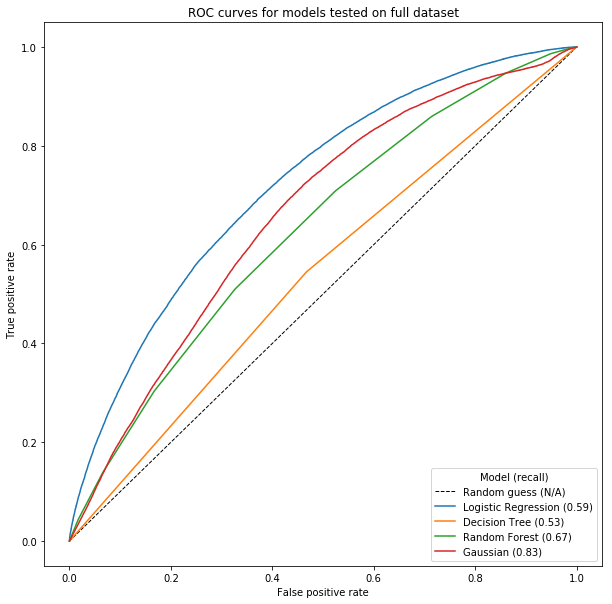

In [14]:
do_full = True

if do_full:
    (X_train_orig, X_test_orig, y_train, y_test) = data_from_dataset("../../data/processed/loan.csv")
    X_train_orig.fillna(0, inplace = True)
    X_test_orig.fillna(0, inplace = True)
    (X_train_under, y_train_under) = undersample_dataset(X_train_orig, y_train)
    X_train = normalize_df(X_train_under)
    X_test = normalize_df(X_test_orig)
    metrics_dict_all = compare_models(X_train, X_test, y_train_under, y_test,
                                     "../../reports/figures/balanced_full.png",
                                     "ROC curves for models tested on full dataset")

## Model choice

In the business context, the metric we are most concerned with is recall: of the loans that default, how many did our model identify?

We make the following observations about each of our models:

- Logistic Regression:
    - High explainability
    - Decrease in performance when training on full dataset
- Decision Tree:
    - High explainability
    - Low metric scores
- Random Forest:
    - Lower explainability: we can use feature importance to show which variables contribute the most, but in the case of our model we see that there are few meaningful attributes to be seen from this. 
    - Performance on-par with logistic regression
- Gaussian Naive Bayes: 
    - Lowest explainability
    - Assumes Normal distribution in data: we have observed normal-like distributions on only some of the columns of the dataset
    - High recall and AUC on full dataset
    
For the sake of brevity, we'll choose one model. In this case, **Gaussian Naive Bayes** seems the best choice: despite its low explainability, it maintains performance when increasing the size of the dataset, and consistently scores the highest in the recall metric. 